<a href="https://colab.research.google.com/github/jackysiupuichung/adme_property_prediction/blob/main/ADME_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version
!nvidia-smi

1.13.0+cu116
11.6
Python 3.8.16
Sat Dec 17 21:50:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

In [31]:
!wget https://github.com/samoturk/mol2vec/raw/master/examples/models/model_300dim.pkl
!pip install git+https://github.com/samoturk/mol2vec
!pip3 install torch torchvision torchaudio
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu117.html
!pip3 install rdkit
!pip install transformers
!pip3 install simpletransformers
!pip3 install sklearn-evaluation

--2022-12-17 22:25:34--  https://github.com/samoturk/mol2vec/raw/master/examples/models/model_300dim.pkl
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/samoturk/mol2vec/master/examples/models/model_300dim.pkl [following]
--2022-12-17 22:25:34--  https://raw.githubusercontent.com/samoturk/mol2vec/master/examples/models/model_300dim.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76786055 (73M) [application/octet-stream]
Saving to: ‘model_300dim.pkl.1’

model_300dim.pkl.1  100%[===================>]  73.23M   399MB/s    in 0.2s    

2022-12-17 22:25:35 (399 MB/s) - ‘model_300dim.pkl.1’ sa

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [65]:
# import packages
import pandas as pd
import numpy as np
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader
#Xgboost tree
import xgboost as xgb
#sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
#utils
import collections
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns

In [6]:
df = pd.read_csv('/content/gdrive/MyDrive/adme_benchmarking/dataframe.csv')

In [69]:
!pip install PyTDC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 10.1 MB/s 
     |████████████████████████████████| 29.3 MB 1.4 MB/s 
  Created wheel for PyTDC: filename=PyTDC-0.3.8-py3-none-any.whl size=136139 sha256=56c5699ff8253a2580cf2516aafa04f119f2ba0a362c2b2590c85e65ef7b8ef0
  Stored in directory: /root/.cache/pip/wheels/4a/4f/da/b494dde823e311675b3ce778ca8c22e734ef8f779dbf311805
Successfully built PyTDC


In [76]:
from tdc.single_pred import ADME
data = ADME(name = 'CYP2C9_Veith')
df = data.get_data()
df = df.rename(columns={"Y": "CYP2D6"})

Found local copy...
Loading...
Done!


In [77]:
print(">>> data shape = ", df.shape)
print(">>> data columns = ", df.columns, "\n")
print()

print(">>> create mol from smiles ... ")
df['mol'] = df['Drug'].apply(lambda x: Chem.MolFromSmiles(x)) 


print(">>> create sentence from mol ... ")
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], radius=1)), axis=1)

print(">>> load the word2vec model ... ")
w2v_model = word2vec.Word2Vec.load('model_300dim.pkl')

print(">>> create embedding from sentence ... ")
df['embedding'] = [DfVec(x) for x in sentences2vec(df['sentence'], w2v_model)]

print(">>> data columns = ", df.columns, "\n")

drug_word_embeddings = np.array([x.vec for x in df['embedding']])
drug_word_embeddings_df = pd.DataFrame(drug_word_embeddings)
print(">>> drug_word_embeddings_df shape = ", drug_word_embeddings_df.shape)

>>> data shape =  (12092, 3)
>>> data columns =  Index(['Drug_ID', 'Drug', 'CYP2D6'], dtype='object') 


>>> create mol from smiles ... 
>>> create sentence from mol ... 
>>> load the word2vec model ... 
>>> create embedding from sentence ... 
>>> data columns =  Index(['Drug_ID', 'Drug', 'CYP2D6', 'mol', 'sentence', 'embedding'], dtype='object') 

>>> drug_word_embeddings_df shape =  (12092, 300)


In [78]:
X_train, X_test, y_train, y_test = train_test_split(drug_word_embeddings_df,
df['CYP2D6'],stratify = df['CYP2D6'], test_size=0.4, random_state=123)

print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(collections.Counter(y_train))
print(y_test.shape)
print(collections.Counter(y_test))

(7255, 300)
(4837, 300)

(7255,)
Counter({0: 4828, 1: 2427})
(4837,)
Counter({0: 3219, 1: 1618})


In [79]:
xgb_estimator = xgb.XGBClassifier(objective='binary:logistic')
# fit the model
xgb_estimator.fit(X_train, y_train)

XGBClassifier()

convert smile representations to pytorch geometric dataset objects
https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/

In [80]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)


def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.long)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

Strongly skewed distribution between the binary labels are shown

In [81]:
train_dataset, test_dataset = train_test_split(df[['Drug', 'CYP2D6']] ,test_size=0.4, stratify = df['CYP2D6'], random_state=123)
test_dataset, val_dataset = train_test_split(test_dataset,test_size=0.5, stratify = test_dataset['CYP2D6'], random_state=123)

print(train_dataset.shape)
print(collections.Counter(train_dataset['CYP2D6']))
print(val_dataset.shape)
print(collections.Counter(val_dataset['CYP2D6']))
print(test_dataset.shape)
print(collections.Counter(test_dataset['CYP2D6']))

(7255, 2)
Counter({0: 4828, 1: 2427})
(2419, 2)
Counter({0: 1610, 1: 809})
(2418, 2)
Counter({0: 1609, 1: 809})


In [82]:
train_dataset_graph = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(train_dataset['Drug'], train_dataset['CYP2D6'])
val_dataset_graph = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(val_dataset['Drug'], val_dataset['CYP2D6'])
test_dataset_graph = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(test_dataset['Drug'], test_dataset['CYP2D6'])

In [83]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset_graph, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset_graph, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset_graph, batch_size=16, shuffle=False)

In [84]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        #79 being the number of features in graphs
        self.conv1 = GCNConv(79, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        #2 being the number of classes for prediction
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(79, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [85]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#adjust for class imbalances
class_weights = torch.tensor([0.195, 0.805])
criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
          out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
          loss = criterion(out, data.y)  # Compute the loss.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          optimizer.zero_grad()  # Clear gradients.

def val(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

def predict(loader):
    model.eval()

    predictions = []
    for data in loader:  # Iterate in batches
        batch_pred = []
        out = model(data.x, data.edge_index, data.batch)  
        predictions.append(out.argmax(dim=1).tolist())
    return [item for sublist in predictions for item in sublist]

In [86]:
for epoch in range(1, 21):
    train()
    train_acc = val(train_loader)
    test_acc = val(val_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5720, Test Acc: 0.5676
Epoch: 002, Train Acc: 0.4223, Test Acc: 0.4155
Epoch: 003, Train Acc: 0.6015, Test Acc: 0.5866
Epoch: 004, Train Acc: 0.7414, Test Acc: 0.7470
Epoch: 005, Train Acc: 0.5711, Test Acc: 0.5581
Epoch: 006, Train Acc: 0.6595, Test Acc: 0.6420
Epoch: 007, Train Acc: 0.6127, Test Acc: 0.5907
Epoch: 008, Train Acc: 0.5176, Test Acc: 0.5023
Epoch: 009, Train Acc: 0.6896, Test Acc: 0.6697
Epoch: 010, Train Acc: 0.7030, Test Acc: 0.6908
Epoch: 011, Train Acc: 0.6518, Test Acc: 0.6465
Epoch: 012, Train Acc: 0.7344, Test Acc: 0.7181
Epoch: 013, Train Acc: 0.6646, Test Acc: 0.6420
Epoch: 014, Train Acc: 0.7101, Test Acc: 0.6933
Epoch: 015, Train Acc: 0.7086, Test Acc: 0.6854
Epoch: 016, Train Acc: 0.6360, Test Acc: 0.6168
Epoch: 017, Train Acc: 0.6852, Test Acc: 0.6598
Epoch: 018, Train Acc: 0.7005, Test Acc: 0.6813
Epoch: 019, Train Acc: 0.6520, Test Acc: 0.6412
Epoch: 020, Train Acc: 0.6635, Test Acc: 0.6437


In [87]:
from simpletransformers.classification import ClassificationModel
import logging
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [88]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model_args = ClassificationArgs()
model_args.train_batch_size = 16
model_args.eval_batch_size = 16 
model_args.evaluate_each_epoch = True
model_args.evaluate_during_training_verbose = True
model_args.no_save = True
model_args.num_train_epochs = 20
model_args.auto_weights = True
model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.001
model_args.early_stopping_metric = "mcc"
model_args.early_stopping_metric_minimize = False
model_args.early_stopping_patience = 5
model_args.evaluate_during_training_steps = 1000

transformer_model = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', args = model_args)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE

In [89]:
print(transformer_model.tokenizer)

PreTrainedTokenizerFast(name_or_path='seyonec/PubChem10M_SMILES_BPE_396_250', vocab_size=7924, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})


In [96]:
# Train the model
# TODO: add early stopping to stop epoch
transformer_model.train_model(train_dataset, eval_df=val_dataset, output_dir='/content/gdrive/MyDrive/adme_benchmarking/transformer/adme_CYP2D6_epoch20_early', overwrite_output_dir = True)

  0%|          | 0/7255 [00:00<?, ?it/s]

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Running Epoch 0 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 1 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 2 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 3 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 4 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 5 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 6 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 7 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 8 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 9 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 10 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 11 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 12 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 13 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 14 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 15 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 16 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 17 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 18 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

Running Epoch 19 of 20:   0%|          | 0/454 [00:00<?, ?it/s]

(9080, 0.11022065673292737)

Test and Evaluation:

sklearn metric used: classification report

we would use the weighted average precision as the primary evaluation metric for comparison, which measures the proportion of predicted Positives that are truly Positive. This is because we want to be sure regarding the model's prediction, and the weighted average adjust for the skewness of sample label distribution

roc_auc_score = 0.751533


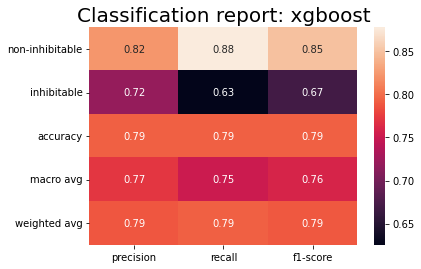

In [97]:
#classification report for xgboost
y_hat = xgb_estimator.predict(X_test)
auc_y1 = roc_auc_score(y_test,y_hat)
print(f'roc_auc_score = {auc_y1:5f}')
clf_report = pd.DataFrame(classification_report(y_test, y_hat, target_names=['non-inhibitable', 'inhibitable'], output_dict=True))
plt.title("Classification report: xgboost", fontsize =20)
sns.heatmap(clf_report.iloc[:-1, :].T, annot=True)

roc_auc_score = 0.710614


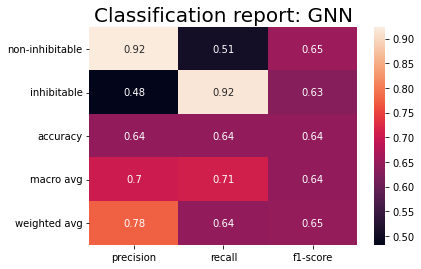

In [98]:
#classification report for GNN
y_hat = predict(test_loader)
auc_y1 = roc_auc_score(test_dataset['CYP2D6'],y_hat)
print(f'roc_auc_score = {auc_y1:5f}')
clf_report = pd.DataFrame(classification_report(test_dataset['CYP2D6'], y_hat, target_names=['non-inhibitable', 'inhibitable'], output_dict=True))
plt.title("Classification report: GNN", fontsize =20)
sns.heatmap(clf_report.iloc[:-1, :].T, annot=True)

  0%|          | 0/2418 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

roc_auc_score = 0.794704


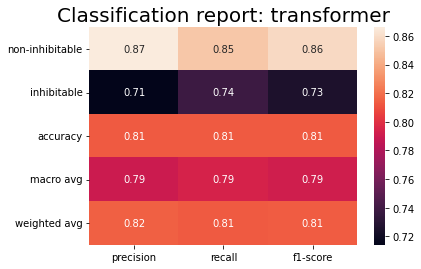

In [99]:
#classification report for transformer
transformer_preds = transformer_model.predict(test_dataset['Drug'].tolist())
y_hat = transformer_preds[0]
auc_y1 = roc_auc_score(test_dataset['CYP2D6'],y_hat)
print(f'roc_auc_score = {auc_y1:5f}')
clf_report = pd.DataFrame(classification_report(test_dataset['CYP2D6'], y_hat, target_names=['non-inhibitable', 'inhibitable'], output_dict=True))
plt.title("Classification report: transformer", fontsize =20)
sns.heatmap(clf_report.iloc[:-1, :].T, annot=True)

Out of the three models, the transformer model performed best in weighted average precision, followed by the xgboost tree, then the GNN model. This is also reflected by the roc_auc_score.

TODOS:


*   perform multi-output classification to increase generalizability
 *  incoperate open target gene network domain knowledge as targeted outputs
*   hyperparameter tuning
*   interpretability and understanding of model components effect
 *  since both the transformer and xgboost tree uses some form of language embedding
 *  feature importance for predictions


Future directions:
* peform on regression tasks (expression, distribution, etc)
